In [2]:
#inserts pylab and numpy in a jupyter notebook. If using python, then these libraries must be manually imported
%pylab inline 
import keras
from skimage.transform import resize
from keras.layers import *
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.optimizers import Adam
import random as rn
import tensorflow as tf 

np.random.seed(123) #to make the experiment reproducible

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

img_h = 256 #image height
img_w = 256 #image width

Populating the interactive namespace from numpy and matplotlib


/home/deepa/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'resize', 'minimum', 'multiply', 'average', 'dot', 'concatenate', 'add', 'subtract', 'maximum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
#loads just the X_train and Y_train using only full slices.
def load_full_slices():
    return np.load('X_train.npy'), np.load('Y_train.npy')

#loads x_test using just full slices. This uses the final test images
def load_x_test(f='x_test_ED.npy'):
    a = np.load(f)
    arr = []
    for i in a:
        b = resize(i, (img_h, img_w))
        arr.append(b)
    return np.array(arr)  

In [4]:
#loads the datasets
X, Y = load_full_slices()
x_test = load_x_test()

/home/deepa/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(30, 256, 256)
(30, 256, 256)


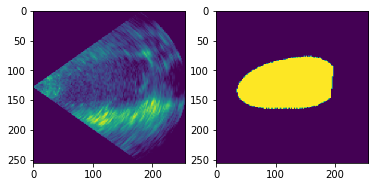

In [5]:
#sanity checks
print(x_test.shape)
z = 28
subplot(121)
imshow(X[z])
subplot(122)
imshow(Y[z])
print(X.shape)

X shape: (30, 256, 256, 1)
Y shape: (30, 256, 256, 1)
x_test: (30, 256, 256, 1)


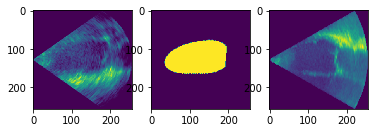

In [6]:
#we reshape the datasets into tensorflow format and normalize them into floats from 0 to 1
X = X.reshape(X.shape[0],256,256,1).astype('float32') / 255
Y = Y.reshape(Y.shape[0],256,256,1)

#same happens for testset
x_test = x_test.reshape(x_test.shape[0],256,256,1).astype('float32') / 255

print ('X shape: ' + str(X.shape))
print ('Y shape: ' + str(Y.shape))
print ('x_test: ' + str(x_test.shape))

z = 28
subplot(131)
imshow(X[z,:,:,0])
subplot(132)
imshow(Y[z,:,:,0])
subplot(133)
imshow(x_test[z,:,:,0])


In [7]:
##Copy paste from Deepa's Code

### From first unet implementation ### 
# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py 
def dice_coef(y_true, y_pred):
    smooth = 1.0 
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### From first unet implementation ### 
# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py 
def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)

def get_unet2(img_rows, img_cols):
    
    inputs = Input((img_rows, img_cols, 1))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    # print ("conv1 shape:" + str(conv1.shape)) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # print ("conv1 shape:" + str(conv1.shape))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # print ("pool1 shape:" + str(pool1.shape))

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    # print "conv2 shape:",conv2.shape
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # print "conv2 shape:",conv2.shape
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # print "pool2 shape:",pool2.shape

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    # print "conv3 shape:",conv3.shape
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # print "conv3 shape:",conv3.shape
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # print "pool3 shape:",pool3.shape

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    # model.compile(optimizer='adam',loss = dice_coef_loss, metrics = [dice_coef, 'accuracy'])
    model.compile(optimizer = Adam(lr = 1e-5),loss = dice_coef_loss, metrics = [dice_coef, 'accuracy'])
   

    return model

In [8]:
#create the model
model = get_unet2(256,256)

/home/deepa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/deepa/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/deepa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:60: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/deepa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:65: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/deepa/anaconda2/lib/python2.7/site

In [9]:
#training
# model.fit(X, Y, batch_size=1, epochs=2, validation_split=0.2)

model.fit(X, Y, batch_size=8, epochs=50, validation_split=0.2)


#if you already trained the model then comment above line and uncomment the one below
#it will load the model fromf file
#model = load_model('model_full_slices.h5')

Train on 24 samples, validate on 6 samples
Epoch 1/50
24/24 [==============================] - 64s 3s/step - loss: -0.2530 - dice_coef: 0.2530 - acc: 0.6230 - val_loss: -0.2894 - val_dice_coef: 0.2894 - val_acc: 0.6463
Epoch 2/50
24/24 [==============================] - 2s 64ms/step - loss: -0.2531 - dice_coef: 0.2531 - acc: 0.6409 - val_loss: -0.2895 - val_dice_coef: 0.2895 - val_acc: 0.6444
Epoch 3/50
24/24 [==============================] - 2s 63ms/step - loss: -0.2531 - dice_coef: 0.2531 - acc: 0.6437 - val_loss: -0.2895 - val_dice_coef: 0.2895 - val_acc: 0.6477
Epoch 4/50
24/24 [==============================] - 2s 66ms/step - loss: -0.2532 - dice_coef: 0.2532 - acc: 0.6477 - val_loss: -0.2895 - val_dice_coef: 0.2895 - val_acc: 0.6494
Epoch 5/50
24/24 [==============================] - 2s 65ms/step - loss: -0.2532 - dice_coef: 0.2532 - acc: 0.6499 - val_loss: -0.2895 - val_dice_coef: 0.2895 - val_acc: 0.6534
Epoch 6/50
24/24 [==============================] - 2s 66ms/step - loss: 

Epoch 47/50
24/24 [==============================] - 2s 67ms/step - loss: -0.7166 - dice_coef: 0.7166 - acc: 0.9109 - val_loss: -0.5633 - val_dice_coef: 0.5633 - val_acc: 0.8932
Epoch 48/50
24/24 [==============================] - 2s 68ms/step - loss: -0.6915 - dice_coef: 0.6915 - acc: 0.9047 - val_loss: -0.6251 - val_dice_coef: 0.6251 - val_acc: 0.8487
Epoch 49/50
24/24 [==============================] - 2s 64ms/step - loss: -0.7098 - dice_coef: 0.7098 - acc: 0.8846 - val_loss: -0.5947 - val_dice_coef: 0.5947 - val_acc: 0.8935
Epoch 50/50
24/24 [==============================] - 2s 68ms/step - loss: -0.7352 - dice_coef: 0.7352 - acc: 0.9140 - val_loss: -0.6287 - val_dice_coef: 0.6287 - val_acc: 0.8599


In [10]:
#saves the whole model (architecture + weights + optimizer state)
model.save("model_full_slices.h5")

In [11]:
#perform predictions on 5 images (my computer has no resources for all 30)
num_predictions = 5
p = model.predict(x_test[:num_predictions,:,:,:], verbose=1)

5/5 [==============================] - 1s 163ms/step


(5, 256, 256, 1)


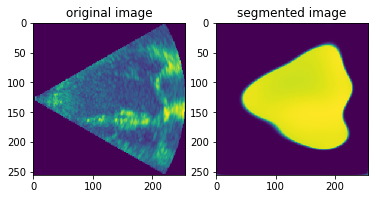

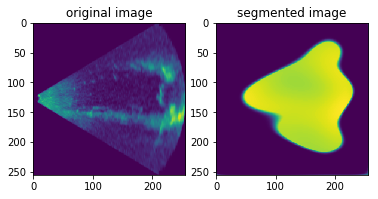

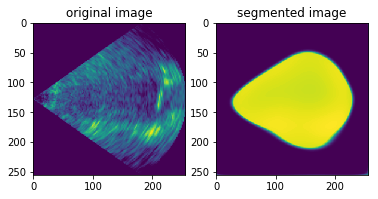

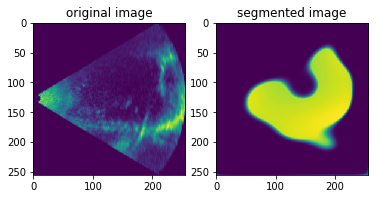

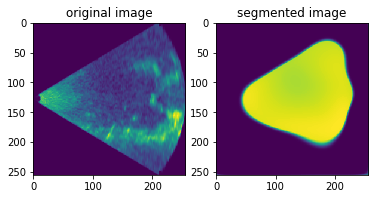

In [12]:
#copy paste from Deepa's code
#transform 
for n in range(num_predictions): 
    p[n,:,:] = (p[n,:,:] * 255.).astype(np.uint8)

 
print(p.shape)
 
# just show the first testing image for now 
num_image = 0
for n in range(5):
    plt.subplot(121)
    plt.imshow(x_test[n,:,:,0])
    plt.title('original image')

    plt.subplot(122)
    plt.imshow(p[n,:,:,0])
    plt.title('segmented image')

    plt.show() 